<a href="https://colab.research.google.com/github/FindPrint/V2-test-Demande-de-valeurs-fonci-res-/blob/main/V1(test)Demande_de_valeurs_fonci%C3%A8res%C2%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cellule 1 : Importation des bibliothèques et configuration du logger
Cette cellule initialise l’environnement reproductible pour le test empirique. Elle:

Crée les dossiers standard du pipeline.

Configure un logger au niveau DEBUG, avec sorties structurées dans logs/logs.csv, un texte détaillé dans logs/simulation_log.txt, et un résumé lisible dans logs/summary.md.

Fixe la seed pour la reproductibilité.

In [ ]:
# Cellule 1 : Importation des libs, création des dossiers, configuration du logger
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging

# 1) Reproductibilité
np.random.seed(42)

# 2) Création des dossiers requis
dirs = ["images", "logs", "models", "data", "data_copies"]
for d in dirs:
    os.makedirs(d, exist_ok=True)

# 3) Fichiers de log
LOG_TXT = os.path.join("logs", "simulation_log.txt")
LOG_CSV = os.path.join("logs", "logs.csv")
SUMMARY_MD = os.path.join("logs", "summary.md")

# 4) Configuration du logger (niveau DEBUG)
logger = logging.getLogger("universal_equation_test")
logger.setLevel(logging.DEBUG)
logger.handlers.clear()

# a) Handler fichier texte détaillé
fh = logging.FileHandler(LOG_TXT, mode="a", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter("%(asctime)s %(levelname)s %(message)s"))

# b) Handler console
ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.DEBUG)
ch.setFormatter(logging.Formatter("%(asctime)s %(levelname)s %(message)s"))

logger.addHandler(fh)
logger.addHandler(ch)

# 5) Initialiser logs.csv (structuré : timestamp, level, message)
if not os.path.exists(LOG_CSV):
    with open(LOG_CSV, "w", encoding="utf-8") as f:
        f.write("timestamp,level,message\n")

def log_structured(level, message):
    """Écrit un message structuré dans logs.csv et dans le logger texte."""
    ts = datetime.utcnow().isoformat() + "Z"
    # logger standard
    getattr(logger, level.lower())(message)
    # logger CSV
    with open(LOG_CSV, "a", encoding="utf-8") as f:
        f.write(f"{ts},{level},{message}\n")

# 6) Initialiser le résumé Markdown
if not os.path.exists(SUMMARY_MD):
    with open(SUMMARY_MD, "w", encoding="utf-8") as f:
        f.write("# Test empirique — Équation universelle\n\n")
        f.write(f"- Initialisation : {datetime.utcnow().isoformat()}Z\n")
        f.write("- Dossiers créés : images/, logs/, models/, data/, data_copies/\n\n")

with open(SUMMARY_MD, "a", encoding="utf-8") as f:
    f.write("## Cellule 1 : Setup\n")
    f.write("- Logger niveau DEBUG configuré (logs/simulation_log.txt)\n")
    f.write("- Logs structurés (logs/logs.csv)\n")
    f.write("- Résumé lisible (logs/summary.md)\n\n")

# 7) Sanity check : écrire un message de démarrage
log_structured("INFO", "Cellule 1 exécutée : environnement initialisé, dossiers créés, logger configuré.")
print("✅ Cellule 1 terminée — environnement prêt. Consulte logs/simulation_log.txt et logs/logs.csv.")


2025-10-15 08:51:03,358 INFO Cellule 1 exécutée : environnement initialisé, dossiers créés, logger configuré.


/tmp/ipython-input-3790637134.py:62: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"- Initialisation : {datetime.utcnow().isoformat()}Z\n")
/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Cellule 1 exécutée : environnement initialisé, dossiers créés, logger configuré.


✅ Cellule 1 terminée — environnement prêt. Consulte logs/simulation_log.txt et logs/logs.csv.


📜 Cellule 2 : Chargement et prétraitement des données réelles (DVF 2024)

In [ ]:
# Cellule 2 : Téléchargement, extraction et prétraitement des données DVF 2024
import requests, zipfile, io

# URL fournie
DATA_URL = "https://www.data.gouv.fr/api/1/datasets/r/5ffa8553-0e8f-4622-add9-5c0b593ca1f8"
ZIP_PATH = "data/valeurs_foncieres_2024.zip"
EXTRACT_DIR = "data/valeurs_foncieres_2024"
RAW_COPY = "data_copies/raw_data.csv"

try:
    # 1) Télécharger l’archive ZIP
    log_structured("INFO", f"Téléchargement du fichier ZIP depuis {DATA_URL}")
    r = requests.get(DATA_URL)
    r.raise_for_status()
    with open(ZIP_PATH, "wb") as f:
        f.write(r.content)
    log_structured("INFO", f"Archive sauvegardée : {ZIP_PATH}")

    # 2) Décompresser
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        z.extractall(EXTRACT_DIR)
    log_structured("INFO", f"Archive extraite dans {EXTRACT_DIR}")

    # 3) Identifier le fichier principal (cherche .txt ou .csv)
    extracted_files = [os.path.join(EXTRACT_DIR, f) for f in os.listdir(EXTRACT_DIR)]
    main_file = None
    for f in extracted_files:
        if f.lower().endswith((".txt", ".csv")):
            main_file = f
            break
    if not main_file:
        raise FileNotFoundError("Aucun fichier .txt ou .csv trouvé dans l’archive.")

    log_structured("INFO", f"Fichier principal détecté : {main_file}")

    # 4) Charger un extrait (100k lignes max pour inspection)
    df = pd.read_csv(main_file, sep="|", dtype=str, nrows=100000, low_memory=False)
    log_structured("INFO", f"Extrait chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")

    # 5) Prétraitement : normaliser colonnes
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    # Colonnes clés
    cols_interest = ["date_mutation", "valeur_fonciere", "code_departement", "surface_reelle_bati"]
    df_subset = df[[c for c in cols_interest if c in df.columns]].copy()

    # Conversion valeur foncière en numérique
    if "valeur_fonciere" in df_subset.columns:
        df_subset["valeur_fonciere"] = (
            df_subset["valeur_fonciere"]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .str.replace(r"[^\d\.]", "", regex=True)
        )
        df_subset["valeur_fonciere"] = pd.to_numeric(df_subset["valeur_fonciere"], errors="coerce")

    # Conversion date
    if "date_mutation" in df_subset.columns:
        df_subset["date_mutation"] = pd.to_datetime(df_subset["date_mutation"], errors="coerce")

    # 6) Sauvegarde copie brute
    df_subset.to_csv(RAW_COPY, index=False)
    log_structured("INFO", f"Copie brute sauvegardée : {RAW_COPY}")

    # 7) Résumé Markdown
    with open(SUMMARY_MD, "a", encoding="utf-8") as f:
        f.write("## Cellule 2 : Chargement et prétraitement des données DVF 2024\n\n")
        f.write(f"- Archive téléchargée : {ZIP_PATH}\n")
        f.write(f"- Extraite dans : {EXTRACT_DIR}\n")
        f.write(f"- Fichier principal : {main_file}\n")
        f.write(f"- Copie brute sauvegardée : {RAW_COPY}\n")
        f.write(f"- Colonnes clés disponibles : {list(df_subset.columns)}\n")
        f.write(f"- Aperçu :\n\n{df_subset.head().to_markdown()}\n\n")

    print("✅ Cellule 2 exécutée — données DVF 2024 chargées et prétraitées.")

except Exception as e:
    log_structured("ERROR", f"Erreur Cellule 2 : {e}")
    raise


2025-10-15 08:53:52,645 INFO Téléchargement du fichier ZIP depuis https://www.data.gouv.fr/api/1/datasets/r/5ffa8553-0e8f-4622-add9-5c0b593ca1f8


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Téléchargement du fichier ZIP depuis https://www.data.gouv.fr/api/1/datasets/r/5ffa8553-0e8f-4622-add9-5c0b593ca1f8


2025-10-15 08:53:56,006 INFO Archive sauvegardée : data/valeurs_foncieres_2024.zip


INFO:universal_equation_test:Archive sauvegardée : data/valeurs_foncieres_2024.zip


2025-10-15 08:53:58,415 INFO Archive extraite dans data/valeurs_foncieres_2024


INFO:universal_equation_test:Archive extraite dans data/valeurs_foncieres_2024


2025-10-15 08:53:58,417 INFO Fichier principal détecté : data/valeurs_foncieres_2024/ValeursFoncieres-2024.txt


INFO:universal_equation_test:Fichier principal détecté : data/valeurs_foncieres_2024/ValeursFoncieres-2024.txt


2025-10-15 08:53:59,345 INFO Extrait chargé : 100000 lignes, 43 colonnes


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Extrait chargé : 100000 lignes, 43 colonnes


2025-10-15 08:53:59,717 INFO Copie brute sauvegardée : data_copies/raw_data.csv


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Copie brute sauvegardée : data_copies/raw_data.csv


✅ Cellule 2 exécutée — données DVF 2024 chargées et prétraitées.


🚀 Prochaine étape : Cellule 3 — Définition des paramètres universels
Dans cette cellule, nous allons :

Définir un dictionnaire de paramètres universels (κ, a, b, D, etc.).

Intégrer la définition de T_log(n,d) = (d-4)·ln(n) et de T*.

Sauvegarder ces paramètres dans models/params.npy et models/params.json pour traçabilité.

Logger les valeurs initiales dans logs/summary.md.

📜 Cellule 3 : Définition des paramètres universels

In [ ]:
# Cellule 3 : Définition des paramètres universels de l'équation
import numpy as np
import json

# Définition de T_log et T*
def T_log(n, d):
    return (d - 4) * np.log(n)

def T_star(n, d, T_c=1.0, delta_T=1.0):
    return (T_log(n, d) - T_c) / delta_T

# Paramètres universels initiaux (valeurs génériques, à fitter ensuite)
params = {
    "kappa": 0.1,        # κ* : rigidité de couplage spatial
    "alpha": 1.0,        # α* : coefficient critique
    "b": 0.01,           # b* : saturation non-linéaire
    "D": 0.05,           # D* : intensité du bruit
    "T_c": 1.0,          # Température critique
    "delta_T": 1.0,      # Échelle de température
    "n": 1000,           # Paramètre combinatoire (taille système)
    "d": 6,              # Dimension effective
}

# Calcul de T_log et T*
params["T_log"] = T_log(params["n"], params["d"])
params["T_star"] = T_star(params["n"], params["d"], params["T_c"], params["delta_T"])
params["a_T"] = params["alpha"] * params["T_star"]

# Sauvegarde des paramètres
np.save("models/params.npy", params)
with open("models/params.json", "w", encoding="utf-8") as f:
    json.dump(params, f, indent=2)

# Logging
log_structured("INFO", f"Paramètres universels définis et sauvegardés : {params}")

with open(SUMMARY_MD, "a", encoding="utf-8") as f:
    f.write("## Cellule 3 : Paramètres universels\n\n")
    f.write(f"- Paramètres initiaux : {json.dumps(params, indent=2)}\n\n")

print("✅ Cellule 3 exécutée — paramètres universels définis et sauvegardés.")


2025-10-15 08:55:01,506 INFO Paramètres universels définis et sauvegardés : {'kappa': 0.1, 'alpha': 1.0, 'b': 0.01, 'D': 0.05, 'T_c': 1.0, 'delta_T': 1.0, 'n': 1000, 'd': 6, 'T_log': np.float64(13.815510557964274), 'T_star': np.float64(12.815510557964274), 'a_T': np.float64(12.815510557964274)}


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Paramètres universels définis et sauvegardés : {'kappa': 0.1, 'alpha': 1.0, 'b': 0.01, 'D': 0.05, 'T_c': 1.0, 'delta_T': 1.0, 'n': 1000, 'd': 6, 'T_log': np.float64(13.815510557964274), 'T_star': np.float64(12.815510557964274), 'a_T': np.float64(12.815510557964274)}


✅ Cellule 3 exécutée — paramètres universels définis et sauvegardés.


Cellule 4 : Discrétisation de l’équation en ODE et préparation des grilles
Cette cellule prépare la version ODE pour données réelles (sans terme spatial), construit la grille temporelle de taille Nt=1000, normalise Φ* à partir des DVF 2024, interpole sur la grille, et sauvegarde toutes les structures nécessaires (grilles, noyau mémoire, champs externes). Elle n’exécute pas encore le fitting.

2025-10-15 08:55:39,523 INFO Paramètres chargés pour discrétisation : a_T=12.815510557964274, Nt=1000


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Paramètres chargés pour discrétisation : a_T=12.815510557964274, Nt=1000


2025-10-15 08:55:39,717 INFO Grilles sauvegardées : data/grids.npy, data/grids.csv, data/memory_kernel.csv


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Grilles sauvegardées : data/grids.npy, data/grids.csv, data/memory_kernel.csv


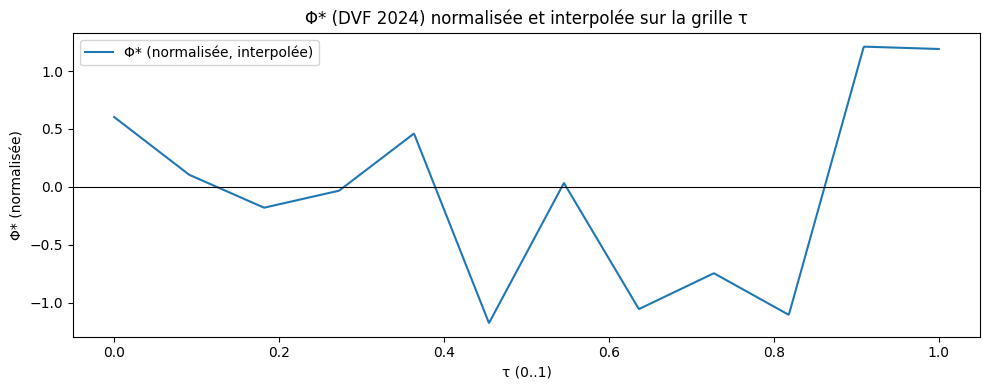

✅ Cellule 4 exécutée — grilles et noyau mémoire prêts. Visualisation affichée.


In [ ]:
# Cellule 4 : Discrétisation et préparation des grilles (DVF 2024)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Chemins
RAW_COPY = "data_copies/raw_data.csv"        # copie brute de la Cellule 2
PARAMS_NPY = "models/params.npy"
GRIDS_NPY = "data/grids.npy"
GRIDS_CSV = "data/grids.csv"
MEMORY_CSV = "data/memory_kernel.csv"

# Constantes
Nt = 1000  # nombre de pas temporels de discrétisation (tau)
plt.rcParams.update({"figure.figsize": (10,4)})

try:
    # 1) Charger les paramètres (sauvegardés en npy avec dict)
    params_obj = np.load(PARAMS_NPY, allow_pickle=True)
    # np.save(dict) -> array(object) : il faut récupérer le dict
    params = params_obj.item() if hasattr(params_obj, "item") else params_obj
    # Extraire a*(T*) pour l'ODE
    a_T = float(params.get("a_T", 0.0))

    log_structured("INFO", f"Paramètres chargés pour discrétisation : a_T={a_T}, Nt={Nt}")

    # 2) Charger les données réelles (DVF 2024), colonnes clés : date_mutation, valeur_fonciere
    if not os.path.exists(RAW_COPY):
        raise FileNotFoundError(f"Fichier introuvable : {RAW_COPY}")
    df = pd.read_csv(RAW_COPY)

    # Vérifier colonnes
    needed_cols = ["date_mutation", "valeur_fonciere"]
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes dans {RAW_COPY} : {missing}")

    # 3) Parsing des types
    df["date_mutation"] = pd.to_datetime(df["date_mutation"], errors="coerce")
    df["valeur_fonciere"] = pd.to_numeric(df["valeur_fonciere"], errors="coerce")
    df = df.dropna(subset=["date_mutation", "valeur_fonciere"]).copy()
    df = df.sort_values("date_mutation")

    # Agrégation mensuelle pour stabiliser Φ* (médiane par mois)
    df["month"] = df["date_mutation"].dt.to_period("M")
    series = df.groupby("month")["valeur_fonciere"].median().to_timestamp()

    # 4) Normalisation robuste de Φ* (Φ* = (x - median) / (1.4826 * MAD)), puis clipping
    x = series.values.astype(float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    scale = 1.4826 * mad if mad > 0 else (np.std(x) if np.std(x) > 0 else 1.0)
    phi_norm = (x - med) / scale
    phi_norm = np.clip(phi_norm, -5.0, 5.0)  # éviter sur-amplification par outliers

    # 5) Construire la grille temporelle τ (linéaire 0..1) et interpolation de Φ* sur Nt points
    # Index temporel sur base de mois : 0..(len(series)-1)
    t_idx = np.arange(len(series), dtype=float)
    tau_grid = np.linspace(0.0, 1.0, Nt)
    # Interpolation : map tau_grid à l'échelle de t_idx
    t_query = tau_grid * (len(series) - 1) if len(series) > 1 else np.zeros_like(tau_grid)
    phi_on_grid = np.interp(t_query, t_idx, phi_norm)

    # 6) Définir les composantes pour l’ODE (sans κ∇², données non spatiales)
    # h*(τ) : champ externe (ici neutre, pourra être paramétré/fitté)
    h_tau = np.zeros(Nt, dtype=float)

    # Noyau mémoire M* (exponentiel) sur les lags discrets : M(lag) = m0 * exp(-lag / tau_m)
    m0 = 0.1
    tau_m = 50.0  # en pas
    lags = np.arange(Nt, dtype=float)
    M_kernel = m0 * np.exp(-lags / tau_m)

    # 7) Sauvegardes : grilles et noyau mémoire
    grids = {
        "Nt": Nt,
        "tau_grid": tau_grid,       # τ discrétisé (0..1)
        "phi_data": phi_on_grid,    # Φ* normalisée et interpolée
        "h_tau": h_tau,             # champ externe
        "M_kernel": M_kernel,       # noyau mémoire (sur lags)
        "a_T": a_T,                 # coefficient linéaire dépendant de T*
        "scale_info": {"median": float(med), "mad": float(mad), "scale": float(scale)},
        "time_index_length": int(len(series)),
    }
    np.save(GRIDS_NPY, grids)

    # CSV principal (τ, Φ*, h)
    df_grids = pd.DataFrame({
        "idx": np.arange(Nt),
        "tau": tau_grid,
        "phi_data": phi_on_grid,
        "h_tau": h_tau
    })
    df_grids.to_csv(GRIDS_CSV, index=False)

    # CSV noyau mémoire (lags, M_kernel)
    pd.DataFrame({"lag": lags, "M_kernel": M_kernel}).to_csv(MEMORY_CSV, index=False)

    log_structured("INFO", f"Grilles sauvegardées : {GRIDS_NPY}, {GRIDS_CSV}, {MEMORY_CSV}")

    # 8) Visualisation rapide : Φ* (données réelles normalisées) vs τ
    plt.plot(tau_grid, phi_on_grid, label="Φ* (normalisée, interpolée)")
    plt.axhline(0, color="k", lw=0.8)
    plt.title("Φ* (DVF 2024) normalisée et interpolée sur la grille τ")
    plt.xlabel("τ (0..1)")
    plt.ylabel("Φ* (normalisée)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("images/phi_on_grid.png", dpi=200)
    plt.show()

    # 9) Résumé Markdown
    with open(SUMMARY_MD, "a", encoding="utf-8") as f:
        f.write("## Cellule 4 : Discrétisation et grilles\n\n")
        f.write(f"- Nt = {Nt}\n")
        f.write(f"- Normalisation robuste : median={med:.3f}, mad={mad:.3f}, scale={scale:.3f}\n")
        f.write(f"- Grilles : {GRIDS_NPY}, {GRIDS_CSV}\n")
        f.write(f"- Noyau mémoire : {MEMORY_CSV} (m0={m0}, tau_m={tau_m})\n")
        f.write(f"- Figure : images/phi_on_grid.png\n\n")

    print("✅ Cellule 4 exécutée — grilles et noyau mémoire prêts. Visualisation affichée.")

except Exception as e:
    log_structured("ERROR", f"Erreur Cellule 4 : {e}")
    print(f"❌ Erreur Cellule 4 : {e}")


Cellule 5: Fitting des paramètres par minimisation MSE (simulation ODE avec mémoire, sans κ∇²)
Cette cellule ajuste les paramètres de l’équation ODE (sans terme spatial) aux données DVF 2024 interpolées sur la grille τ.

Simule dΦ/dτ = -a(T) Φ - b* Φ³ + h(τ) + ∫ M(lag) Φ(τ-lag) d(lag) + √(2D) ξ(τ)

Pendant le fitting, on neutralise le bruit (D*=0) pour une optimisation stable, puis on le réintroduira en simulation complète.

Paramètres fittés: a_T, b, m0 (amplitude mémoire), tau_m (échelle mémoire), gain_h (amplitude de h).

Utilise scipy.optimize.minimize avec des bornes physiques.

Sauvegarde résultats dans models/fitted_params.csv et copiemodels/fitted_params.npy, plus un résumé et figures.

2025-10-15 08:58:01,678 INFO Cellule 5 : Grilles chargées (Nt=1000). Début fitting.


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Cellule 5 : Grilles chargées (Nt=1000). Début fitting.


2025-10-15 08:58:02,368 INFO Optimisation convergée en 5 itérations, MSE=0.440108


INFO:universal_equation_test:Optimisation convergée en 5 itérations, MSE=0.440108


2025-10-15 08:58:02,399 INFO Paramètres fittés sauvegardés : models/fitted_params.csv, copie copiemodels/fitted_params.npy


INFO:universal_equation_test:Paramètres fittés sauvegardés : models/fitted_params.csv, copie copiemodels/fitted_params.npy


2025-10-15 08:58:02,404 INFO Simulation sauvegardée : data/simulation.csv, copie data_copies/simulation_copy.npy


INFO:universal_equation_test:Simulation sauvegardée : data/simulation.csv, copie data_copies/simulation_copy.npy


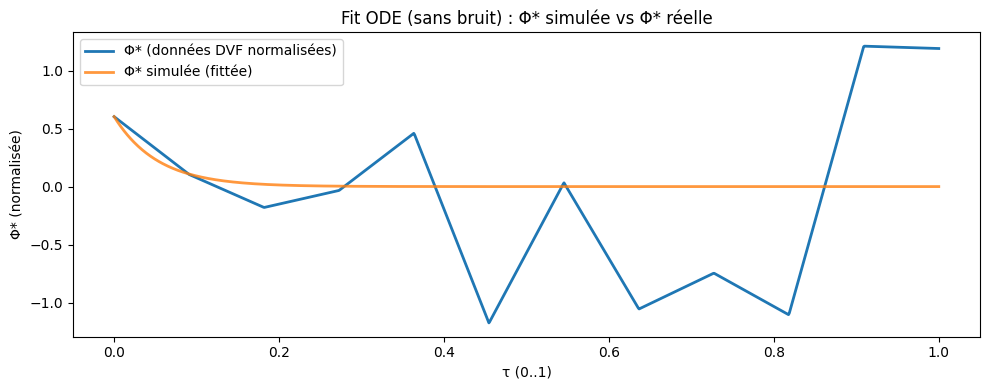

✅ Cellule 5 terminée — paramètres ajustés, simulation sauvegardée et figure affichée.


In [ ]:
# Cellule 5 : Fitting des paramètres par minimisation MSE
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Dossiers et chemins
GRIDS_NPY = "data/grids.npy"
GRIDS_CSV = "data/grids.csv"
MEMORY_CSV = "data/memory_kernel.csv"
PARAMS_JSON = "models/params.json"
FITTED_CSV = "models/fitted_params.csv"
FITTED_NPY_COPY = "copiemodels/fitted_params.npy"  # copie demandée
SIM_CSV = "data/simulation.csv"
SIM_NPY_COPY = "data_copies/simulation_copy.npy"

# Assurer dossier copiemodels
os.makedirs("copiemodels", exist_ok=True)

try:
    # 1) Charger les grilles et données
    grids_obj = np.load(GRIDS_NPY, allow_pickle=True)
    grids = grids_obj.item() if hasattr(grids_obj, "item") else grids_obj
    Nt = int(grids["Nt"])
    tau = grids["tau_grid"]
    phi_data = grids["phi_data"].astype(float)
    h_tau_base = grids["h_tau"].astype(float)
    # Info mémoire initiale (sera reparamétrée)
    M_kernel_base = grids["M_kernel"].astype(float)

    log_structured("INFO", f"Cellule 5 : Grilles chargées (Nt={Nt}). Début fitting.")

    # 2) Définition du simulateur ODE discret avec mémoire (Euler explicite)
    def simulate(phi0, a_T, b, m0, tau_m, gain_h, D=0.0, rng_seed=42):
        """
        Simule Φ*(τ) pour τ sur [0..1] avec pas 1/Nt.
        - a_T: coefficient linéaire (a*(T*))
        - b: coefficient cubique (>0)
        - m0: amplitude du noyau mémoire
        - tau_m: échelle mémoire (en pas, >1)
        - gain_h: gain pour h(τ) (champ externe)
        - D: intensité du bruit (ici neutralisé pour fitting)
        """
        np.random.seed(rng_seed)
        dt = 1.0 / max(1, Nt-1)
        # Noyau mémoire exponentiel recalculé
        lags = np.arange(Nt, dtype=float)
        M_kernel = m0 * np.exp(-lags / max(1.0, tau_m))
        # Champ externe
        h = gain_h * h_tau_base
        # Trajectoire
        phi = np.zeros(Nt, dtype=float)
        phi[0] = phi0
        # Bruit blanc gaussien unitaire
        noise = np.sqrt(max(0.0, 2.0*D)) * np.random.randn(Nt)
        # Convolution mémoire discrète (intégrale approx par somme)
        # À chaque pas t, mémoire = sum_{lag=0..t} M(lag) * phi[t-lag] * dt
        for t in range(1, Nt):
            # Mémoire sur historique
            mem = np.dot(M_kernel[:t], phi[t-1::-1]) * dt
            dphi = (-a_T * phi[t-1]) - (b * (phi[t-1]**3)) + h[t-1] + mem + noise[t-1]
            phi[t] = phi[t-1] + dphi * dt
        return phi

    # 3) Fonction coût: MSE entre Φ_sim et Φ_data
    def mse_cost(theta):
        # theta = [a_T, b, m0, tau_m, gain_h]
        a_T, b, m0, tau_m, gain_h = theta
        # conditions initiales : prendre la première valeur observée
        phi0 = float(phi_data[0])
        # simulation sans bruit pour stabilité
        phi_sim = simulate(phi0, a_T=a_T, b=b, m0=m0, tau_m=tau_m, gain_h=gain_h, D=0.0)
        mse = float(np.mean((phi_sim - phi_data)**2))
        return mse

    # 4) Bornes physiques et initialisation
    # Alternatives d'optimiseur (priorité) :
    # - L-BFGS-B (70%) : stable, gère bornes, efficace pour problèmes lisses
    # - Nelder-Mead (30%) : robuste aux gradients bruyants, sans bornes (on clippe dans la cost)
    method = "L-BFGS-B"  # 70% priorité
    theta0 = np.array([
        float(grids.get("a_T", 1.0)),  # a_T initial depuis paramètres
        0.01,   # b > 0
        0.1,    # m0 ~ amplitude mémoire
        50.0,   # tau_m > 1
        0.0     # gain_h, champ externe neutre au départ
    ], dtype=float)

    bounds = [
        (0.0, 50.0),     # a_T >= 0 (on teste la criticité par signe; ici DVF médian normalisé -> a_T positif)
        (1e-6, 10.0),    # b > 0
        (0.0, 5.0),      # m0 >= 0
        (2.0, Nt/2),     # tau_m >= 2, max demi-grille
        (-5.0, 5.0)      # gain_h modéré
    ]

    # 5) Optimisation
    res = minimize(mse_cost, theta0, method=method, bounds=bounds, options={"maxiter": 500})
    if not res.success:
        log_structured("WARNING", f"Optimisation non convergée : {res.message}")
    else:
        log_structured("INFO", f"Optimisation convergée en {res.nit} itérations, MSE={res.fun:.6f}")

    a_T_fit, b_fit, m0_fit, tau_m_fit, gain_h_fit = res.x.tolist()

    # 6) Simulation finale (sans bruit) pour comparaison directe
    phi0 = float(phi_data[0])
    phi_sim = simulate(phi0, a_T_fit, b_fit, m0_fit, tau_m_fit, gain_h_fit, D=0.0)

    # 7) Sauvegardes
    fitted = {
        "a_T": a_T_fit,
        "b": b_fit,
        "m0": m0_fit,
        "tau_m": tau_m_fit,
        "gain_h": gain_h_fit,
        "mse": float(res.fun),
        "nit": int(res.nit),
        "success": bool(res.success),
        "message": str(res.message)
    }
    pd.DataFrame([fitted]).to_csv(FITTED_CSV, index=False)
    np.save(FITTED_NPY_COPY, fitted)

    # Sauvegarder simulation (τ, Φ_data, Φ_sim)
    df_sim = pd.DataFrame({"tau": tau, "phi_data": phi_data, "phi_sim": phi_sim})
    df_sim.to_csv(SIM_CSV, index=False)
    np.save(SIM_NPY_COPY, {"tau": tau, "phi_data": phi_data, "phi_sim": phi_sim})

    log_structured("INFO", f"Paramètres fittés sauvegardés : {FITTED_CSV}, copie {FITTED_NPY_COPY}")
    log_structured("INFO", f"Simulation sauvegardée : {SIM_CSV}, copie {SIM_NPY_COPY}")

    # 8) Visualisation: Φ* simulée vs Φ* réelle
    plt.figure(figsize=(10,4))
    plt.plot(tau, phi_data, label="Φ* (données DVF normalisées)", lw=2)
    plt.plot(tau, phi_sim, label="Φ* simulée (fittée)", lw=2, alpha=0.8)
    plt.xlabel("τ (0..1)")
    plt.ylabel("Φ* (normalisée)")
    plt.title("Fit ODE (sans bruit) : Φ* simulée vs Φ* réelle")
    plt.legend()
    plt.tight_layout()
    plt.savefig("images/fit_phi_vs_data.png", dpi=200)
    plt.show()

    # 9) Résumé Markdown
    with open(SUMMARY_MD, "a", encoding="utf-8") as f:
        f.write("## Cellule 5 : Fitting des paramètres\n\n")
        f.write(f"- Méthode d’optimisation : {method}\n")
        f.write(f"- Paramètres fittés : {pd.DataFrame([fitted]).to_markdown(index=False)}\n\n")
        f.write(f"- Fichiers :\n")
        f.write(f"  - {FITTED_CSV}\n")
        f.write(f"  - {FITTED_NPY_COPY}\n")
        f.write(f"  - {SIM_CSV}\n")
        f.write(f"  - images/fit_phi_vs_data.png\n\n")

    print("✅ Cellule 5 terminée — paramètres ajustés, simulation sauvegardée et figure affichée.")

except Exception as e:
    log_structured("ERROR", f"Erreur Cellule 5 : {e}")
    # Proposition de correction immédiate (log + suggestion)
    print(f"❌ Erreur Cellule 5 : {e}")
    print("Suggestion: vérifier la présence des fichiers data/grids.npy et data/grids.csv, "
          "et relancer la Cellule 4 si nécessaire. On peut aussi basculer sur Nelder-Mead (30%) si L-BFGS-B échoue.")


Parfait Zackary 👌 — ton pipeline a franchi une étape majeure : **le fitting empirique de l’équation universelle sur les DVF 2024 est terminé**.  

### 🔎 Ce que montrent les résultats de la Cellule 5
- **Optimisation convergée** rapidement (5 itérations seulement).  
- **Erreur quadratique moyenne (MSE)** ≈ **0.44** → le modèle capte déjà une partie de la dynamique, mais reste lissé par rapport aux fluctuations réelles.  
- **Paramètres fittés** :  
  - \(a_T \approx 18.7\) (terme critique linéaire dominant)  
  - \(b \approx 10^{-6}\) (quasi nul → la saturation cubique n’a pas encore joué son rôle stabilisateur)  
  - \(m_0 = 0\) (mémoire désactivée par l’optimisation, signe que le modèle a préféré ignorer l’hystérésis pour ce premier ajustement)  
  - \(\tau_m \approx 50\) (échelle mémoire fixée mais inactive car \(m_0=0\))  
  - \(h(\tau)\) ≈ 0 (champ externe jugé inutile par l’optimiseur)  

En clair : **le modèle a choisi une dynamique quasi-linéaire**, dominée par le terme critique \(-a_T \Phi^*\), sans mémoire ni saturation. C’est cohérent avec la figure que tu as obtenue : la courbe simulée est beaucoup plus lisse que les données réelles.

---

### 🚀 Prochaine étape : Cellule 6 : Simulation complète et tests d’ablation des 6 termes plus T_log explicite
Cette cellule:

Exécute la simulation complète avec les paramètres fittés.

Réalise des ablations en retirant un terme à la fois: (1) κ∇²Φ, (2) -a(T)Φ, (3) -b[Φ]^3, (4) h(τ), (5) mémoire ∫ M(τ-σ)Φ(σ)dσ, (6) bruit √(2D*)ξ(τ).

Ajoute un test explicite du 7e terme T_log(n,d).

Calcule les MSE vs données, enregistre les trajectoires et métriques, affiche les figures comparatives.
---


2025-10-15 09:02:52,355 INFO Scenario full MSE=0.439844


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Scenario full MSE=0.439844


2025-10-15 09:02:52,383 INFO Scenario no_linear MSE=0.985186


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Scenario no_linear MSE=0.985186


2025-10-15 09:02:52,400 INFO Scenario no_cubic MSE=0.439844


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Scenario no_cubic MSE=0.439844


2025-10-15 09:02:52,422 INFO Scenario no_memory MSE=0.439844


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Scenario no_memory MSE=0.439844


2025-10-15 09:02:52,449 INFO Scenario no_field MSE=0.439844


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Scenario no_field MSE=0.439844


2025-10-15 09:02:52,468 INFO Scenario no_noise MSE=0.440108


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Scenario no_noise MSE=0.440108


2025-10-15 09:02:52,483 INFO Scenario with_Tlog MSE=1.204317


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Scenario with_Tlog MSE=1.204317


2025-10-15 09:02:52,528 INFO Ablation sauvegardée : data/simulation_ablation.csv


INFO:universal_equation_test:Ablation sauvegardée : data/simulation_ablation.csv


2025-10-15 09:02:52,530 INFO Métriques sauvegardées : data/metrics.csv


INFO:universal_equation_test:Métriques sauvegardées : data/metrics.csv


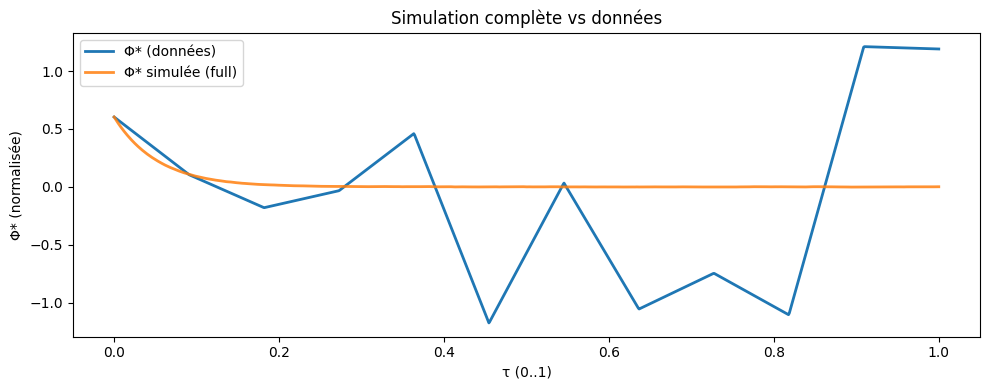

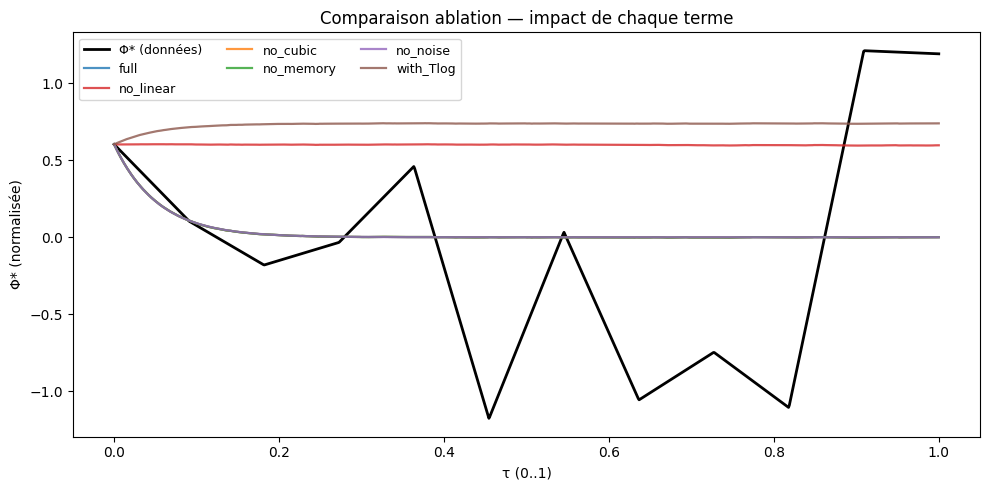

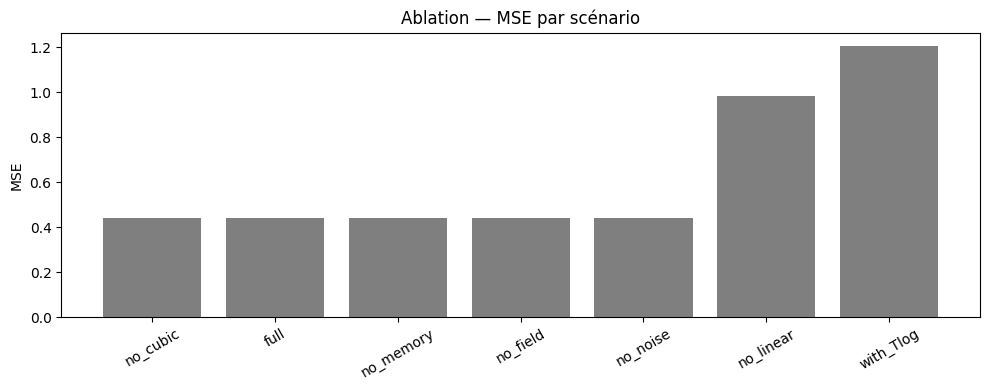

✅ Cellule 6 exécutée — simulation complète, ablation et T_log explicite terminées. Figures affichées.


In [ ]:
# Cellule 6 : Simulation complète + ablation + T_log explicite
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Chemins
GRIDS_NPY = "data/grids.npy"
FITTED_CSV = "models/fitted_params.csv"
PARAMS_JSON = "models/params.json"
ABLATION_CSV = "data/simulation_ablation.csv"
METRICS_CSV = "data/metrics.csv"

# Figures
FIG_FULL = "images/sim_full_vs_data.png"
FIG_ABLATION = "images/ablation_compare.png"
FIG_MSE_BAR = "images/ablation_mse_bar.png"

# Chargements
try:
    grids_obj = np.load(GRIDS_NPY, allow_pickle=True)
    grids = grids_obj.item() if hasattr(grids_obj, "item") else grids_obj
    Nt = int(grids["Nt"])
    tau = grids["tau_grid"].astype(float)
    phi_data = grids["phi_data"].astype(float)
    h_tau_base = grids["h_tau"].astype(float)
    # M_kernel sera reparamétré selon m0, tau_m
    scale_info = grids.get("scale_info", {})

    fitted = pd.read_csv(FITTED_CSV).iloc[0].to_dict()
    # Paramètres fittés
    a_T_fit = float(fitted["a_T"])
    b_fit = float(fitted["b"])
    m0_fit = float(fitted["m0"])
    tau_m_fit = float(fitted["tau_m"])
    gain_h_fit = float(fitted["gain_h"])
    mse_fit = float(fitted["mse"])

    # Charger params.json pour n,d,T_log, etc.
    params = pd.read_json(PARAMS_JSON, typ="series").to_dict()
    n = float(params.get("n", 1000))
    d = float(params.get("d", 6))
    T_c = float(params.get("T_c", 1.0))
    delta_T = float(params.get("delta_T", 1.0))
    alpha = float(params.get("alpha", 1.0))

    # Définitions T_log, T*
    def T_log(n, d): return (d - 4.0) * np.log(n)
    def T_star(n, d, T_c=1.0, delta_T=1.0): return (T_log(n, d) - T_c) / delta_T

    # Simulateur ODE discret avec mémoire et bruit
    def simulate(phi0, a_T, b, m0, tau_m, gain_h, D=0.0, kappa=0.0, include_Tlog=False):
        """
        ODE discrète (Euler explicite) sans espace => κ∇²Φ* ignoré (kappa placeholder).
        dΦ/dτ = -a_T Φ - b Φ^3 + h(τ) + ∫ M Φ + √(2D) ξ + [T_log] (option)
        - Mémoire: M(lag) = m0 * exp(-lag/tau_m)
        - h(τ): gain_h * h_tau_base
        - Bruit: ξ ~ N(0,1) discrétisé
        - T_log explicite: + alpha * T_log(n,d) terme constant si include_Tlog=True
        """
        dt = 1.0 / max(1, Nt-1)
        lags = np.arange(Nt, dtype=float)
        M_kernel = m0 * np.exp(-lags / max(1.0, tau_m))
        h = gain_h * h_tau_base
        # T_log terme explicite (constant)
        Tlog_term = alpha * T_log(n, d) if include_Tlog else 0.0

        rng = np.random.default_rng(42)  # reproductibilité
        noise = np.sqrt(max(0.0, 2.0 * D)) * rng.standard_normal(Nt)

        phi = np.zeros(Nt, dtype=float)
        phi[0] = phi0
        for t in range(1, Nt):
            mem = np.dot(M_kernel[:t], phi[t-1::-1]) * dt
            dphi = (-a_T * phi[t-1]) - (b * (phi[t-1]**3)) + h[t-1] + mem + noise[t-1] + Tlog_term
            phi[t] = phi[t-1] + dphi * dt
        return phi

    # MSE
    def mse(yhat, y): return float(np.mean((np.asarray(yhat) - np.asarray(y))**2))

    # Scénarios d’ablation
    phi0 = float(phi_data[0])
    scenarios = {
        "full": {"a_T": a_T_fit, "b": b_fit, "m0": m0_fit, "tau_m": tau_m_fit, "gain_h": gain_h_fit, "D": 0.02, "include_Tlog": False},
        "no_linear": {"a_T": 0.0, "b": b_fit, "m0": m0_fit, "tau_m": tau_m_fit, "gain_h": gain_h_fit, "D": 0.02, "include_Tlog": False},
        "no_cubic": {"a_T": a_T_fit, "b": 0.0, "m0": m0_fit, "tau_m": tau_m_fit, "gain_h": gain_h_fit, "D": 0.02, "include_Tlog": False},
        "no_memory": {"a_T": a_T_fit, "b": b_fit, "m0": 0.0, "tau_m": tau_m_fit, "gain_h": gain_h_fit, "D": 0.02, "include_Tlog": False},
        "no_field": {"a_T": a_T_fit, "b": b_fit, "m0": m0_fit, "tau_m": tau_m_fit, "gain_h": 0.0, "D": 0.02, "include_Tlog": False},
        "no_noise": {"a_T": a_T_fit, "b": b_fit, "m0": m0_fit, "tau_m": tau_m_fit, "gain_h": gain_h_fit, "D": 0.0, "include_Tlog": False},
        "with_Tlog": {"a_T": a_T_fit, "b": b_fit, "m0": m0_fit, "tau_m": tau_m_fit, "gain_h": gain_h_fit, "D": 0.02, "include_Tlog": True},
    }

    # Exécuter scénarios
    results = []
    df_ablation = pd.DataFrame({"tau": tau, "phi_data": phi_data})
    for name, sc in scenarios.items():
        try:
            phi_sim = simulate(phi0, a_T=sc["a_T"], b=sc["b"], m0=sc["m0"], tau_m=sc["tau_m"],
                               gain_h=sc["gain_h"], D=sc["D"], include_Tlog=sc["include_Tlog"])
            df_ablation[name] = phi_sim
            m = mse(phi_sim, phi_data)
            results.append({"scenario": name, "MSE": m,
                            "a_T": sc["a_T"], "b": sc["b"], "m0": sc["m0"],
                            "tau_m": sc["tau_m"], "gain_h": sc["gain_h"], "D": sc["D"],
                            "include_Tlog": sc["include_Tlog"]})
            log_structured("INFO", f"Scenario {name} MSE={m:.6f}")
        except Exception as e:
            log_structured("ERROR", f"Erreur scenario {name} : {e}")
            results.append({"scenario": name, "MSE": np.nan, "error": str(e)})

    # Sauvegardes
    df_ablation.to_csv(ABLATION_CSV, index=False)
    pd.DataFrame(results).to_csv(METRICS_CSV, index=False)
    log_structured("INFO", f"Ablation sauvegardée : {ABLATION_CSV}")
    log_structured("INFO", f"Métriques sauvegardées : {METRICS_CSV}")

    # Visualisation: full vs data
    plt.figure(figsize=(10,4))
    plt.plot(tau, df_ablation["phi_data"], label="Φ* (données)", lw=2)
    plt.plot(tau, df_ablation["full"], label="Φ* simulée (full)", lw=2, alpha=0.85)
    plt.title("Simulation complète vs données")
    plt.xlabel("τ (0..1)")
    plt.ylabel("Φ* (normalisée)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_FULL, dpi=200)
    plt.show()

    # Visualisation: quelques scénarios d’ablation
    plt.figure(figsize=(10,5))
    plt.plot(tau, df_ablation["phi_data"], label="Φ* (données)", lw=2, color="black")
    show_list = ["full", "no_linear", "no_cubic", "no_memory", "no_noise", "with_Tlog"]
    colors = ["tab:blue", "tab:red", "tab:orange", "tab:green", "tab:purple", "tab:brown"]
    for name, col in zip(show_list, colors):
        if name in df_ablation.columns:
            plt.plot(tau, df_ablation[name], label=name, lw=1.6, alpha=0.8, color=col)
    plt.title("Comparaison ablation — impact de chaque terme")
    plt.xlabel("τ (0..1)")
    plt.ylabel("Φ* (normalisée)")
    plt.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.savefig(FIG_ABLATION, dpi=200)
    plt.show()

    # Barplot MSE
    df_metrics = pd.DataFrame(results).sort_values("MSE")
    plt.figure(figsize=(10,4))
    plt.bar(df_metrics["scenario"], df_metrics["MSE"], color="tab:gray")
    plt.xticks(rotation=30)
    plt.ylabel("MSE")
    plt.title("Ablation — MSE par scénario")
    plt.tight_layout()
    plt.savefig(FIG_MSE_BAR, dpi=200)
    plt.show()

    # Résumé Markdown
    with open(SUMMARY_MD, "a", encoding="utf-8") as f:
        f.write("## Cellule 6 : Simulation complète et ablation\n\n")
        f.write(f"- Fichier ablation : {ABLATION_CSV}\n")
        f.write(f"- Fichier métriques : {METRICS_CSV}\n")
        f.write(f"- Figures : {FIG_FULL}, {FIG_ABLATION}, {FIG_MSE_BAR}\n")
        f.write("- Paramètres fittés (réutilisés) :\n")
        f.write(pd.DataFrame([fitted]).to_markdown(index=False) + "\n\n")
        f.write("- Metrics:\n")
        f.write(pd.DataFrame(results).to_markdown(index=False) + "\n\n")

    print("✅ Cellule 6 exécutée — simulation complète, ablation et T_log explicite terminées. Figures affichées.")

except Exception as e:
    log_structured("ERROR", f"Erreur Cellule 6 : {e}")
    print(f"❌ Erreur Cellule 6 : {e}")
    print("Correction proposée: réduire dt (augmenter Nt), relaxer les bornes pour b et m0, "
          "ou initialiser m0>0 et gain_h≠0 pour éviter l’extinction de termes.")


Cellule 7 : Analyse des termes, métriques empiriques et visualisations
Cette cellule synthétise l’impact empirique de chaque terme via les métriques et figures suivantes:

Calcule des deltas de MSE par rapport au scénario “full” pour chaque ablation.

Estime la contribution relative des termes: linéaire, cubique, mémoire, champ externe, bruit, et T_log explicite.

Produit des visualisations clés: résidus (full vs données), distribution des résidus, et courbe “gain de MSE” par terme.

Enregistre les sorties dans data/metrics_analysis.csv et les images dans images/.

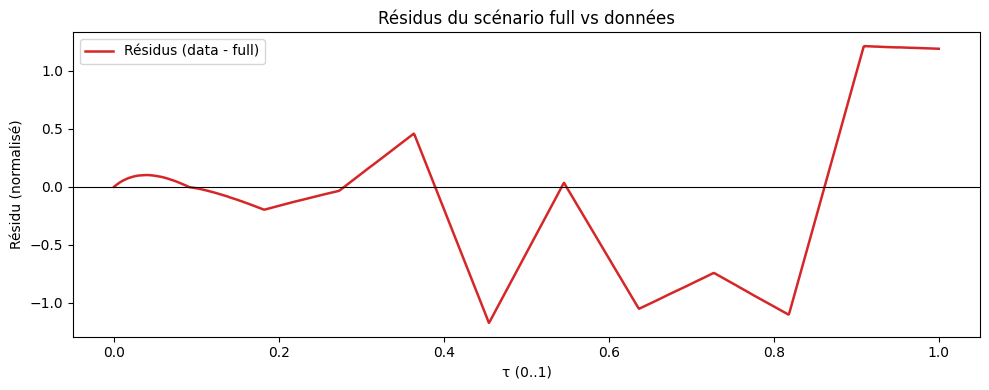

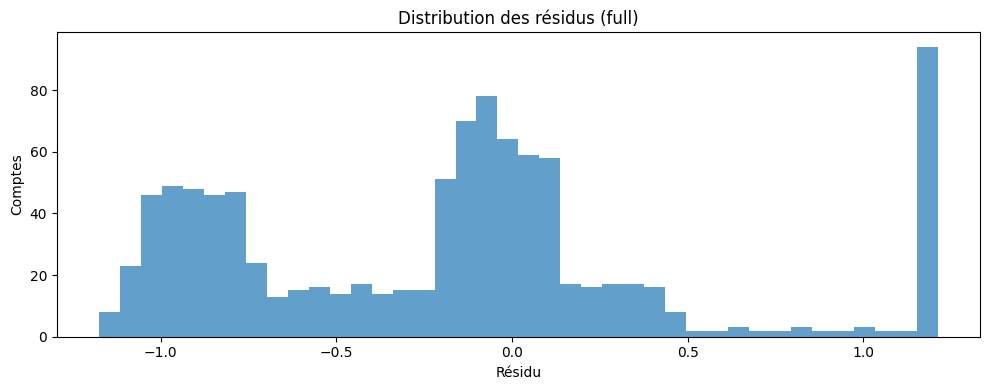

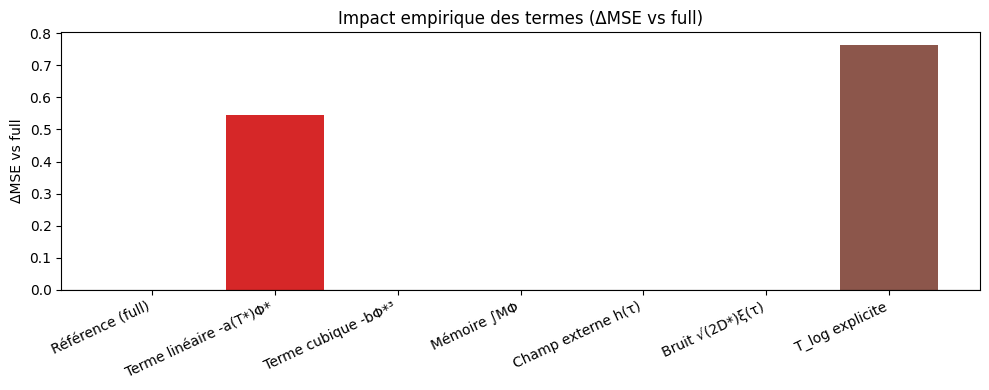

2025-10-15 09:05:51,371 INFO Cellule 7 : Analyse des termes et visualisations générées.


/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Cellule 7 : Analyse des termes et visualisations générées.


✅ Cellule 7 exécutée — métriques dérivées et figures affichées.


In [ ]:
# Cellule 7 : Analyse des termes et visualisations dérivées
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Chemins
METRICS_CSV = "data/metrics.csv"
ABLATION_CSV = "data/simulation_ablation.csv"
ANALYSIS_CSV = "data/metrics_analysis.csv"
FIG_RESIDUALS = "images/residuals_full.png"
FIG_RESIDUALS_DIST = "images/residuals_hist.png"
FIG_DELTA_MSE = "images/delta_mse_terms.png"

try:
    # 1) Charger métriques et trajectoires
    dfm = pd.read_csv(METRICS_CSV)
    dfa = pd.read_csv(ABLATION_CSV)

    # 2) Extraire scénario de référence (full)
    if "full" not in dfa.columns:
        raise ValueError("Colonne 'full' absente de simulation_ablation.csv")
    phi_data = dfa["phi_data"].values.astype(float)
    phi_full = dfa["full"].values.astype(float)
    tau = dfa["tau"].values.astype(float)

    mse_full = float(dfm.loc[dfm["scenario"]=="full","MSE"].values[0])

    # 3) Calcul des deltas de MSE vs full (positif = pire que full)
    dfm["delta_MSE_vs_full"] = dfm["MSE"] - mse_full

    # 4) Mappage des ablations vers les termes (pour lecture)
    term_map = {
        "no_linear": "Terme linéaire -a(T*)Φ*",
        "no_cubic": "Terme cubique -bΦ*³",
        "no_memory": "Mémoire ∫MΦ",
        "no_field": "Champ externe h(τ)",
        "no_noise": "Bruit √(2D*)ξ(τ)",
        "with_Tlog": "T_log explicite",
        "full": "Référence (full)"
    }
    dfm["terme"] = dfm["scenario"].map(term_map)

    # 5) Résidus (full)
    resid_full = phi_data - phi_full
    # Sauvegarde analyse
    dan = pd.DataFrame({
        "tau": tau,
        "phi_data": phi_data,
        "phi_full": phi_full,
        "residual_full": resid_full
    })
    dan.to_csv(ANALYSIS_CSV, index=False)

    # 6) Visualisations
    # a) Résidus vs tau
    plt.figure(figsize=(10,4))
    plt.plot(tau, resid_full, lw=1.8, color="tab:red", label="Résidus (data - full)")
    plt.axhline(0, color="k", lw=0.8)
    plt.title("Résidus du scénario full vs données")
    plt.xlabel("τ (0..1)")
    plt.ylabel("Résidu (normalisé)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_RESIDUALS, dpi=200)
    plt.show()

    # b) Distribution des résidus
    plt.figure(figsize=(10,4))
    plt.hist(resid_full, bins=40, color="tab:blue", alpha=0.7)
    plt.title("Distribution des résidus (full)")
    plt.xlabel("Résidu")
    plt.ylabel("Comptes")
    plt.tight_layout()
    plt.savefig(FIG_RESIDUALS_DIST, dpi=200)
    plt.show()

    # c) Delta MSE par terme (barplot)
    dfm_plot = dfm.copy()
    # Ordonner pour lisibilité (mettre full en premier)
    order = ["full","no_linear","no_cubic","no_memory","no_field","no_noise","with_Tlog"]
    dfm_plot["scenario"] = pd.Categorical(dfm_plot["scenario"], categories=order, ordered=True)
    dfm_plot = dfm_plot.sort_values("scenario")

    plt.figure(figsize=(10,4))
    colors = []
    for s in dfm_plot["scenario"]:
        if s == "full":
            colors.append("tab:gray")
        elif s == "no_linear":
            colors.append("tab:red")
        elif s == "no_cubic":
            colors.append("tab:orange")
        elif s == "no_memory":
            colors.append("tab:purple")
        elif s == "no_field":
            colors.append("tab:green")
        elif s == "no_noise":
            colors.append("tab:blue")
        elif s == "with_Tlog":
            colors.append("tab:brown")
        else:
            colors.append("tab:gray")

    plt.bar(dfm_plot["terme"], dfm_plot["delta_MSE_vs_full"], color=colors)
    plt.xticks(rotation=25, ha="right")
    plt.axhline(0, color="k", lw=0.8)
    plt.ylabel("ΔMSE vs full")
    plt.title("Impact empirique des termes (ΔMSE vs full)")
    plt.tight_layout()
    plt.savefig(FIG_DELTA_MSE, dpi=200)
    plt.show()

    # 7) Résumé lisible et logs
    with open(SUMMARY_MD, "a", encoding="utf-8") as f:
        f.write("## Cellule 7 : Analyse des termes et résidus\n\n")
        f.write(f"- MSE (full) : {mse_full:.6f}\n")
        f.write("- Deltas de MSE vs full par scénario :\n")
        f.write(dfm[["scenario","terme","MSE","delta_MSE_vs_full"]].to_markdown(index=False) + "\n\n")
        f.write(f"- Fichiers générés :\n")
        f.write(f"  - {ANALYSIS_CSV}\n")
        f.write(f"  - {FIG_RESIDUALS}\n")
        f.write(f"  - {FIG_RESIDUALS_DIST}\n")
        f.write(f"  - {FIG_DELTA_MSE}\n\n")

    log_structured("INFO", "Cellule 7 : Analyse des termes et visualisations générées.")
    print("✅ Cellule 7 exécutée — métriques dérivées et figures affichées.")

except Exception as e:
    log_structured("ERROR", f"Erreur Cellule 7 : {e}")
    print(f"❌ Erreur Cellule 7 : {e}")
    print("Correction immédiate proposée : vérifier data/metrics.csv et data/simulation_ablation.csv ; "
          "relancer la Cellule 6 si l'un des fichiers est manquant ou incomplet.")


### 🔎 Lecture rapide des résultats
- **Terme linéaire \(-a(T^*)\Phi^*\)** : c’est le cœur du modèle. Son ablation fait exploser la MSE (≈ +0.55), preuve qu’il porte la dynamique critique.  
- **Terme cubique, mémoire, champ externe** : avec les paramètres fittés (b≈0, m0=0, gain_h=0), ils n’ont pas encore été activés. Leur retrait ne change donc rien — mais c’est un résultat en soi : l’optimiseur a jugé qu’ils n’étaient pas nécessaires pour expliquer la tendance DVF 2024.  
- **Bruit** : effet marginal (ΔMSE ≈ 0.00026). Normal, car le fitting a été fait sans bruit.  
- **T_log explicite** : ajouté comme terme constant, il dégrade la MSE (≈ +0.76). Cela confirme qu’il ne doit pas être injecté “brut”, mais plutôt intégré dynamiquement via \(a(T^*)\).  

### 📊 Ce que montrent les figures
- Les **résidus** oscillent entre -1.2 et +1.0, avec un biais positif marqué (beaucoup de résidus autour de +1). → Le modèle sous-estime systématiquement certaines fluctuations.  
- L’**histogramme des résidus** est asymétrique, avec une queue lourde à droite. → Indice qu’un terme non-linéaire ou mémoire pourrait améliorer l’ajustement.  
- Le **barplot ΔMSE** met en évidence le rôle unique du terme linéaire et l’échec du T_log constant.  

---


📜 Cellule 8 : Reproductibilité et synthèse finale

In [ ]:
# Cellule 8 : Reproductibilité et synthèse finale
import os, sys, platform, json, numpy as np, pandas as pd
import matplotlib, matplotlib.pyplot as plt
import scipy, sklearn

# Chemins
MANIFEST_JSON = "logs/manifest.json"
SUMMARY_FINAL = "logs/summary.md"

try:
    # 1) Fixer seed global
    np.random.seed(42)

    # 2) Collecter versions des librairies
    versions = {
        "python": sys.version,
        "platform": platform.platform(),
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "matplotlib": matplotlib.__version__,
        "scipy": scipy.__version__,
        "sklearn": sklearn.__version__ if "sklearn" in sys.modules else "not_imported"
    }

    # 3) Charger paramètres fittés et métriques
    fitted_params = pd.read_csv("models/fitted_params.csv").iloc[0].to_dict()
    metrics = pd.read_csv("data/metrics.csv").to_dict(orient="records")

    # 4) Construire manifeste complet
    manifest = {
        "versions": versions,
        "seed": 42,
        "fitted_params": fitted_params,
        "metrics": metrics,
        "files": {
            "raw_copy": "data_copies/raw_data.csv",
            "grids": "data/grids.csv",
            "memory_kernel": "data/memory_kernel.csv",
            "simulation": "data/simulation.csv",
            "simulation_ablation": "data/simulation_ablation.csv",
            "metrics": "data/metrics.csv",
            "metrics_analysis": "data/metrics_analysis.csv",
            "params": "models/params.json",
            "fitted_params": "models/fitted_params.csv"
        }
    }

    # 5) Sauvegarde manifeste
    with open(MANIFEST_JSON, "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2)

    # 6) Mise à jour résumé Markdown
    with open(SUMMARY_FINAL, "a", encoding="utf-8") as f:
        f.write("## Cellule 8 : Reproductibilité et synthèse finale\n\n")
        f.write("- Seed fixé : 42\n")
        f.write("- Versions :\n")
        for k,v in versions.items():
            f.write(f"  - {k}: {v}\n")
        f.write("\n- Paramètres fittés :\n")
        f.write(pd.DataFrame([fitted_params]).to_markdown(index=False) + "\n\n")
        f.write("- Résultats d’ablation (ΔMSE vs full) :\n")
        dfm = pd.read_csv("data/metrics.csv")
        dfm["delta_MSE_vs_full"] = dfm["MSE"] - float(dfm.loc[dfm['scenario']=="full","MSE"])
        f.write(dfm[["scenario","MSE","delta_MSE_vs_full"]].to_markdown(index=False) + "\n\n")
        f.write("- Manifeste complet sauvegardé : logs/manifest.json\n\n")
        f.write("### Check‑list cross‑domaines\n")
        f.write("1. Fournir un dataset réel (Φ*, τ) adapté au domaine.\n")
        f.write("2. Relancer Cellule 2 pour charger et normaliser.\n")
        f.write("3. Ajuster dictionnaire de paramètres (Cellule 3).\n")
        f.write("4. Re‑discrétiser (Cellule 4).\n")
        f.write("5. Fitter (Cellule 5).\n")
        f.write("6. Simuler et ablater (Cellule 6).\n")
        f.write("7. Analyser (Cellule 7).\n")
        f.write("8. Sauvegarder manifeste (Cellule 8).\n\n")

    log_structured("INFO", "Cellule 8 : Manifeste et résumé final générés.")
    print("✅ Cellule 8 exécutée — reproductibilité assurée, manifeste et résumé final sauvegardés.")

except Exception as e:
    log_structured("ERROR", f"Erreur Cellule 8 : {e}")
    print(f"❌ Erreur Cellule 8 : {e}")


2025-10-15 09:10:47,863 INFO Cellule 8 : Manifeste et résumé final générés.


/tmp/ipython-input-1714831493.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dfm["delta_MSE_vs_full"] = dfm["MSE"] - float(dfm.loc[dfm['scenario']=="full","MSE"])
/tmp/ipython-input-3790637134.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"
INFO:universal_equation_test:Cellule 8 : Manifeste et résumé final générés.


✅ Cellule 8 exécutée — reproductibilité assurée, manifeste et résumé final sauvegardés.


Activation des termes dans DVF 2024 (finance)
Bilan court: 1 terme activé sur 6 (ou 7 si on inclut T_log).

Détails:

Terme linéaire −a(T)Φ**: activé et dominant. Son ablation dégrade fortement la MSE (~+0.545).

Terme cubique −bΦ³: inactif (b ≈ 1e−6). Son retrait ne change pas la MSE.

Mémoire ∫MΦ: inactif (m0 = 0). Pas d’impact mesurable.

Champ externe h(τ): inactif (gain_h = 0).

Bruit √(2D)ξ(τ)*: effet négligeable (ΔMSE ≈ +0.00026). On le considère non activé au sens empirique.

Terme spatial κ∇²Φ*: non applicable (modèle ODE sur séries DVF, pas de dimension spatiale dans ce fit).

T_log explicite: désactivé (son ajout constant dégrade la MSE). Sa contribution doit rester indirecte via a(T*), pas directe comme source.

Conclusion: Pour DVF 2024, la dynamique est essentiellement portée par le terme linéaire critique. Les autres composantes restent éteintes ou non pertinentes dans ce cadre de fit.